## Introduction

**Polymer recycling** is a way to reduce environmental problems caused by the accumulation of `plastic waste`, which results from the widespread use of `polymer materials` in everyday products. Recycling polymers not only helps reduce waste but also conserves natural resources, as most polymer materials are derived from fossil fuels like **oil** and **gas**.

**Polymer recycling labels** are a way to identify the different types of plastic materials in order to facilitate `sorting` and `recycling`. These labels typically fall into two main categories:

**1. Resin Identification Codes (RIC)**: These are numeric codes, usually ranging from 1 to 7, that correspond to different types of plastic resins. They help recycling facilities determine how to process each polymer:

* **1 (PET or PETE)**: Polyethylene Terephthalate (e.g, beverage bottles)
* **2 (HDPE)**: High-Density Polyethylene (e.g, milk jugs)
* **3 (PVC)**: Polyvinyl Chloride (e.g, pipes, flooring)
* **4 (LDPE)**: Low-Density Polyethylene (e.g, grocery bags)
* **5 (PP)**: Polypropylene (e.g, yogurt containers)
* **6 (PS)**: Polystyrene (e.g, disposable cutlery, foam packaging)
* **7 (Other)**: Other plastics, including multi-layer materials and newer resins like polycarbonate.

**2. Recycling Logos/Instructions**: These labels indicate if a product is recyclable and may include arrows, a number, and specific instructions about how to recycle the item (e.g., "clean and dry before recycling"). Some labels also provide information about whether the material is **biodegradable** or **compostable**.

The aim is to standardize `polymer identification`, reduce contamination in recycling streams, and promote more efficient `material recovery`. However, manual sorting based on these labels is time-consuming, error-prone, and inefficient. Therefore, we will examine whether a **machine learning model** can accomplish this task instead.

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
%matplotlib inline

# Machine Learning Models
import os
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, MaxPool2D

# Model for Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

## Preprocessing

In [2]:
path="Plastic Recycling Codes"
categories = os.listdir(path)
print(categories)

['HDPE', 'LDPE', 'no_plastic', 'other_resins', 'PET', 'PP', 'PS', 'PVC']


### Load Data

In [3]:
# Creating dataframe by iterating through filepaths
def create_image_dataframe(dataset_dir):
    data = []
    
    image_extensions = ['*.png', '*.jpg', '*.jpeg',]
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(dataset_dir, '**', ext), recursive=True))
    
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        data.append((label, path))
    
    df = pd.DataFrame(data, columns=['labels', 'filepaths'])
    return df

This **[dataset](https://www.kaggle.com/datasets/piaoya/plastic-recycling-codes/data)** contains images of various `polymer recycling labels`, organized into multiple categories such as **HDPE**, **PP**, **PET**, and others.

In [4]:
df = create_image_dataframe(path)
df.head()

,labels,filepaths
0,HDPE,Plastic Recycling Codes\HDPE\e02deaf6-310d-4e7...
1,HDPE,Plastic Recycling Codes\HDPE\FGMB6974.jpg
2,HDPE,Plastic Recycling Codes\HDPE\GDKA5806.jpg
3,HDPE,Plastic Recycling Codes\HDPE\IMG_6260.jpg
4,HDPE,Plastic Recycling Codes\HDPE\IMG_6261.jpg


### Class Balance
A **problem** may arise when the number of instances in each `class` of a `dataset` is not balanced. This has a significant impact on the performance of **machine learning models**. The `models` trained on such data tend to be biased towards the `majority class`.

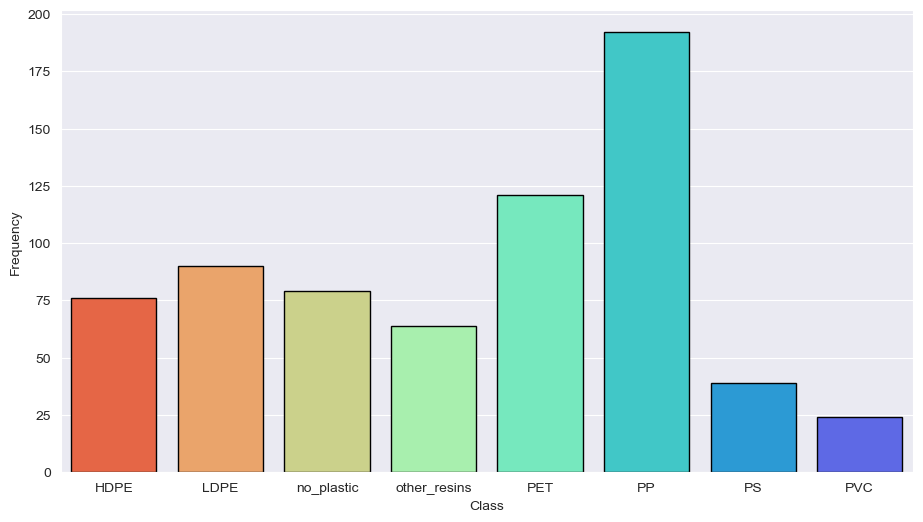

In [5]:
#Choose a style for the plot
sns.set_style("darkgrid")

plt.subplots(figsize=(11, 6))
sns.countplot(x='labels', data=df, hue='labels', palette = "rainbow_r", edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency');

In this case, there are too many `classes` and too little `data`, so we will leave only the classes with the largest number of `samples`.

In [6]:
df_new = df.groupby('labels').filter(lambda x : len(x)>80)

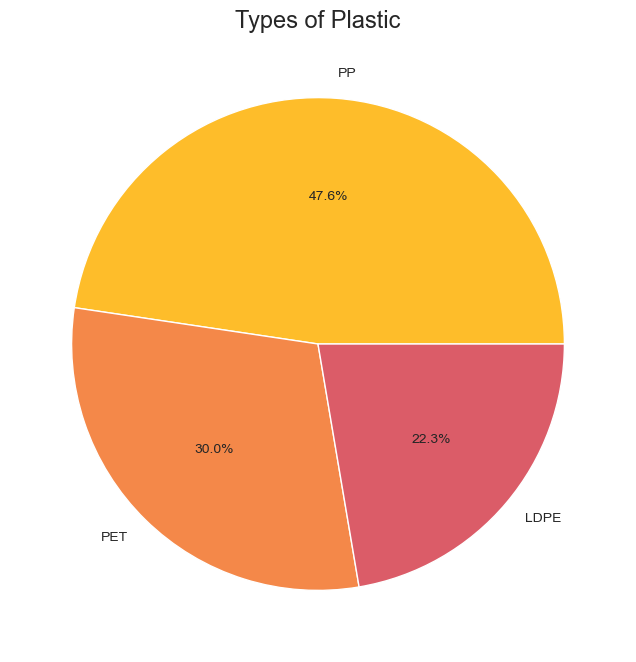

In [7]:
# types of plastic
names = df_new.labels.value_counts().index
sizes = df_new.labels.value_counts().values
plt.figure(figsize = (8,8))
plt.pie(sizes, labels=names, colors=sns.color_palette("plasma_r"), autopct='%1.1f%%')
plt.title('Types of Plastic',fontsize = 17);

The `plastic materials` we are left with are **LDPE**, **PP**, and **PET**. Before proceeding with classification, we will provide a brief description of each one of them.

**LDPE (Low-Density Polyethylene)**: **LDPE** is a type of thermoplastic polymer made from the polymerization of ethylene monomers **(C₂H₄)** using `free-radical polymerization`. The polymer chains in **LDPE** have a `highly branched structure`, which leads to a lower density and a more flexible material compared to other polyethylenes. This branching prevents the polymer chains from packing tightly together, resulting in `lower crystallinity` and `increased amorphousness`. The lower density and amorphous structure contribute to its flexibility, transparency, and ease of processing. **LDPE** exhibits excellent chemical resistance, particularly to acids, bases, and alcohols, and it is resistant to moisture and environmental stress cracking. However, it has relatively `poor mechanical strength` and is susceptible to oxidation at high temperatures. **LDPE** is commonly used in film production, plastic bags, and containers for liquids due to its excellent resistance to water and other chemicals.

**PP (Polypropylene)**: Polypropylene is a semi-crystalline thermoplastic polymer that is synthesized from the polymerization of propylene monomers **(C₃H₆)** through a `coordination polymerization mechanism`, typically using **Ziegler-Natta catalysts** or **metallocene catalysts**. The polymerization process yields polypropylene chains that are less branched compared to **LDPE**, leading to higher crystallinity and a more rigid structure. This increased crystallinity provides **polypropylene** with higher tensile strength, better chemical resistance, and greater thermal stability, with a melting point around **160–170°C**. The polymer exhibits a high degree of resistance to chemical attack from solvents, acids, and bases, making it suitable for a broad range of applications, including food containers, automotive parts, and textiles. Additionally, **polypropylene** is known for its `fatigue resistance`, meaning it can undergo repeated bending and stretching without failing. Polypropylene is also relatively easy to process, making it one of the most commonly used thermoplastics in manufacturing.

**PET (Polyethylene Terephthalate)**: **Polyethylene terephthalate** is a crystalline, high-performance thermoplastic polymer synthesized by the polycondensation reaction between terephthalic acid **(C₆H₄(CO₂H)₂)** and ethylene glycol **(C₂H₆O₂)**. This reaction forms an ester bond **(-COO-)** between the monomers, creating long, linear polymer chains that exhibit high rigidity and strength due to their crystalline structure. **PET** is known for its excellent tensile strength, thermal stability, and resistance to `environmental stress cracking`, which makes it ideal for applications that require durability, such as beverage bottles and food containers. PET’s high molecular weight and its highly crystalline nature contribute to its resistance to `moisture` and `chemical degradation`, while its transparency makes it a popular choice for packaging materials. **PET** is also highly recyclable, often used as a feedstock for recycled fibers, which are then converted into fabrics for clothing or carpeting. Due to its **polar ester groups**, **PET** has a high affinity for water, but it is also resistant to many organic solvents, oils, and greases. The ability to undergo an efficient recycling process is a significant advantage in reducing plastic waste.

In [8]:
# Setup random seed
np.random.seed(50)

#splitting data
train_set, val_set = train_test_split(df_new, test_size=0.2)

#shape of splitted data
print(train_set.shape)
print(val_set.shape)

(322, 2)
(81, 2)


### Data augmentation
**Data augmentation** is a technique used in **machine learning** to artificially increase the size of a **training dataset** by applying various transformations to the existing data. These transformations can include `rotation`, `scaling`, `flipping`, `shifting`, and more, helping to increase the diversity of the training data and improve the model's **generalization ability**.

In [9]:
# Setup random seed
np.random.seed(50)

gen = ImageDataGenerator(rescale=1/255)

train = gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(80,80),
                                      color_mode= 'rgb',
                                      batch_size=32)

test = gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                     target_size=(80,80),
                                     color_mode= 'rgb',
                                     batch_size=32,
                                     shuffle=False)

val = gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(80,80),
                                    color_mode= 'rgb',
                                    batch_size=32)

Found 322 validated image filenames belonging to 3 classes.
Found 81 validated image filenames belonging to 3 classes.
Found 81 validated image filenames belonging to 3 classes.


In [10]:
def show_images(image_gen):
    g_dict = image_gen.class_indices      
    classes = list(g_dict.keys())
    images, labels = next(image_gen)

    plt.figure(figsize= (20, 20))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        image = images[i]      # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color="black",fontsize=17)
        plt.axis('off')

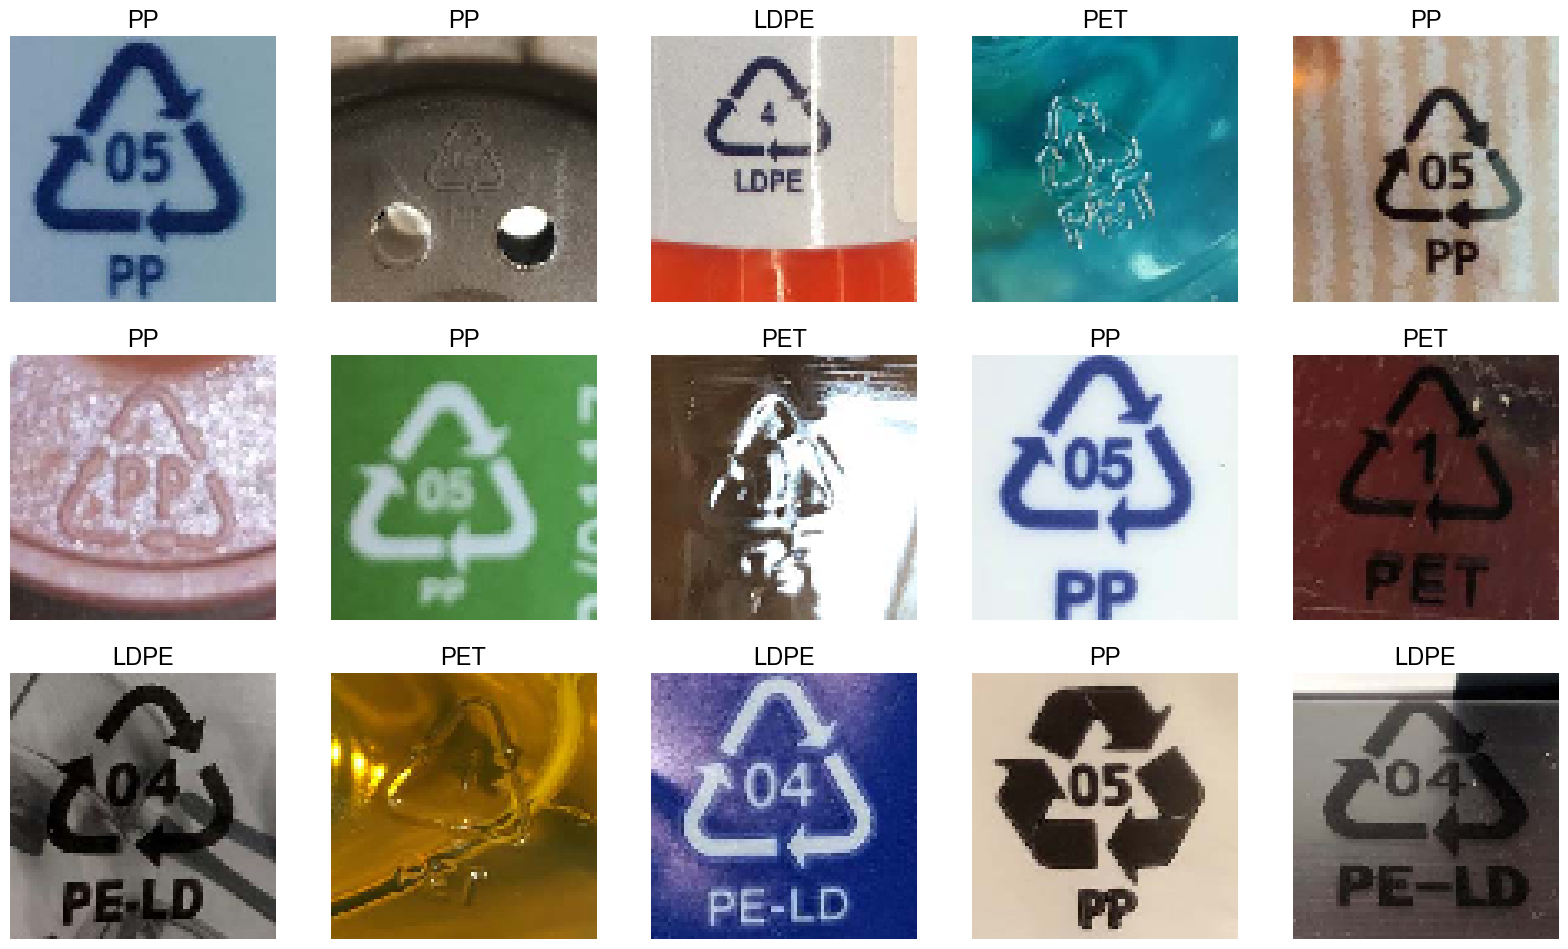

In [11]:
show_images(test)

## Machine learning

We will use **Keras** to build a **Convolutional Neural Network (CNN)** and train it on the available image dataset. **CNNs** are a type of `deep learning models` primarily used for processing grid-like data, such as images. They are designed to automatically detect patterns and features by applying convolutional layers that use filters or kernels to scan through the data. **CNNs** typically consist of several layers: `convolutional layers`, `pooling layers` (to reduce spatial dimensions), and `fully connected layers` (for final classification or regression). This architecture allows **CNNs** to efficiently learn spatial hierarchies of features, making them particularly effective for tasks like `image classification`, `object detection`, and `image generation`.

In [12]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), activation="relu", input_shape=(80,80,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=16,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(16,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 39, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          82,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,779 (335.07 KB)

 Trainable params: 85,779 (335.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Setup random seed
np.random.seed(50)

history = model.fit(train, validation_data=val, epochs=40, verbose=1)

Epoch 1/40


C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5213 - loss: 1.0654 - val_accuracy: 0.3457 - val_loss: 1.2137
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5679 - loss: 1.0070 - val_accuracy: 0.3457 - val_loss: 1.1012
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5014 - loss: 1.0119 - val_accuracy: 0.3457 - val_loss: 1.1503
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5027 - loss: 0.9940 - val_accuracy: 0.3457 - val_loss: 1.0939
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4880 - loss: 0.9706 - val_accuracy: 0.4321 - val_loss: 1.0646
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5539 - loss: 0.9966 - val_accuracy: 0.4444 - val_loss: 1.0334
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6003 - loss: 0.9197 - val_accuracy: 0.4691 - val_loss: 1.0599
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5568 - loss: 0.9313 - val_accuracy: 0.4568 - val_loss: 1

## Evaluate model

In [14]:
def training_history(model):
    train_loss = model.history['loss']
    train_acc = model.history['accuracy']
    val_loss = model.history['val_loss']
    val_acc = model.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    #Choose a style for the plot
    plt.style.use("default")

    # Create a figure and axes with 1 row and 2 columns
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

    ax[0].plot(epochs, train_loss, 'y', label='Training loss')
    ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend();

    ax[1].plot(epochs, train_acc, 'y', label='Training acc')
    ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend();

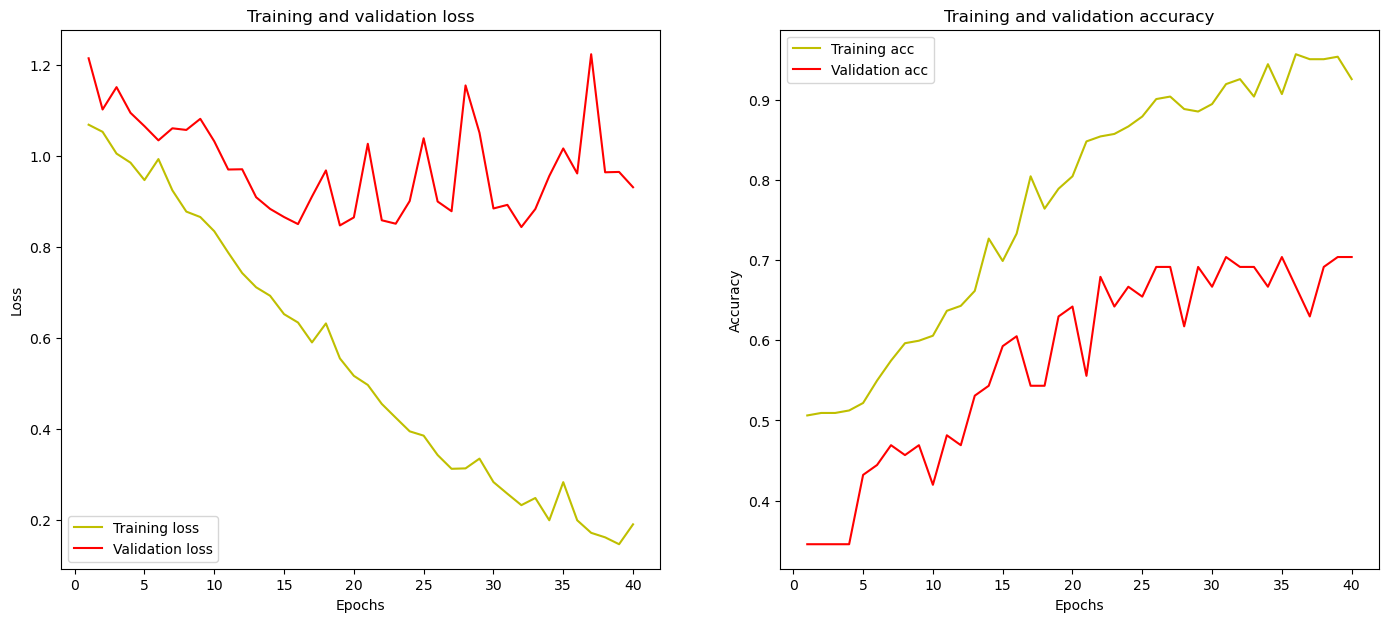

In [15]:
training_history(history)

In [16]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [17]:
y_test = val_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

        LDPE       0.81      0.59      0.68        22
         PET       0.71      0.65      0.68        31
          PP       0.65      0.86      0.74        28

    accuracy                           0.70        81
   macro avg       0.73      0.70      0.70        81
weighted avg       0.72      0.70      0.70        81

Accuracy of the Model: 70.37037037037037 %


### Confusion Matrix
A **confusion matrix** is a table that shows the `performance` of a **classification model** by comparing the `predicted` and actual `class labels`, showing the number of `true positives`, `true negatives`, `false positives`, and `false negatives`.  It helps to evaluate how well the **model** is making `correct predictions` and where it may be making errors.

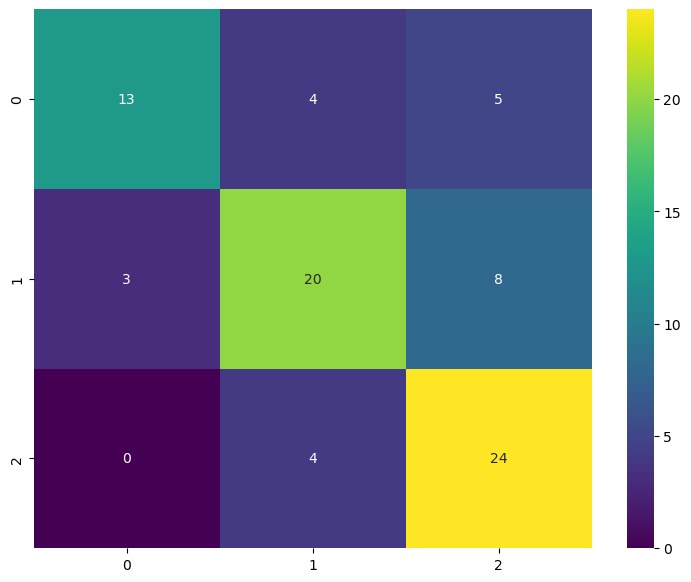

In [18]:
# Making a Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, pred2)

plt.figure(figsize=(9, 7))
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True);

## Testing on New Data

In [19]:
def predict(img_path, img_shape, class_names):
    image = load_img(img_path, target_size = (img_shape,img_shape))
    image = np.expand_dims(image,axis=0)
    
    result = np.argmax(model.predict(image/255),axis=1)
    pred_class = class_names[result[0]]

    plt.figure(figsize=(6, 4))
    plt.imshow(load_img(img_path, target_size = (img_shape,img_shape)))
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


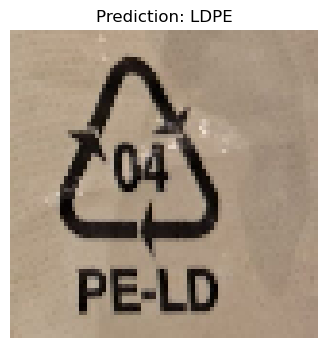

In [23]:
predict('LDPE.jpg', 80, ['LDPE', 'PET', 'PP'])